In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    file_name = 'data1/' + file_name[41:]
    
    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Grouping all texts files
A dataframe is first created to keep individual files at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#list of the file names
files_list = os.listdir('data1')

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [11]:
# for verification purposes later, count the nr of characters for each content
sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
sources['file_len'].sum()

1779770

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# variable containing all documents together
all_texts = ''
for i in range(len(sources)):
  all_texts += sources['file_content'][i]

In [14]:
# check length
len(all_texts)

1779770

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# add new column in df with processed tokens
sources['tokens_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalnum() and len(w) > 3 )])

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['tokens_prep_nostop'] = sources['tokens_prep'].apply(lambda x: [w for w in x if not w in spacy_it_sw])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['tokens_stemmed'] = sources['tokens_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['tokens_lemmatized'] = sources['tokens_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['tokens_lemmatized']

# 2. Topics with LDA

In [0]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [0]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [34]:
# sort descending
words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

,word,frequency
95,aggiungere,6
4,anarchico,4
30,amico,4
99,aggiungere,3
15,agosto,3
73,anarchico,3
10,alia,3
44,alia,3
47,alia,3
28,abbassare,2


## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 6

### 2.2.1 LDA with Gensim

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [37]:
ldagensim.print_topics()

[(0,
  '0.009*"italiano" + 0.005*"dispaccio" + 0.004*"italia" + 0.004*"potere" + 0.003*"roma" + 0.003*"telegrafico" + 0.003*"venire" + 0.002*"giornale" + 0.002*"daily" + 0.002*"dire"'),
 (1,
  '0.007*"italiano" + 0.004*"dispaccio" + 0.003*"telegrafico" + 0.003*"roma" + 0.003*"italia" + 0.003*"potere" + 0.003*"daily" + 0.002*"giornale" + 0.002*"mentire" + 0.002*"nome"'),
 (2,
  '0.008*"italiano" + 0.004*"dispaccio" + 0.004*"telegrafico" + 0.003*"italia" + 0.003*"roma" + 0.003*"daily" + 0.003*"venire" + 0.002*"giornale" + 0.002*"cardinale" + 0.002*"potere"'),
 (3,
  '0.006*"italiano" + 0.004*"roma" + 0.004*"dispaccio" + 0.003*"italia" + 0.003*"venire" + 0.003*"telegrafico" + 0.003*"cardinale" + 0.003*"daily" + 0.003*"potere" + 0.002*"giornale"'),
 (4,
  '0.008*"italiano" + 0.005*"italia" + 0.003*"roma" + 0.003*"dispaccio" + 0.003*"venire" + 0.003*"telegrafico" + 0.003*"giornale" + 0.003*"potere" + 0.003*"daily" + 0.002*"cardinale"'),
 (5,
  '0.008*"italiano" + 0.004*"roma" + 0.004*"itali

### 2.2.2 Visualize topics

In [0]:
# pyLDAvis installation
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 6 topics
%%capture
numtopics = 6
selected_model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus, id2word)

In [40]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004698  0.000878       1        1  40.318825
4     -0.001931  0.000777       2        1  30.218828
2     -0.000880  0.001946       3        1  11.978460
5      0.000043 -0.005219       4        1   6.552164
3      0.004223  0.002364       5        1   6.319992
1      0.003243 -0.000746       6        1   4.611743, topic_info=             Term         Freq        Total Category  logprob  loglift
270      italiano  1015.000000  1015.000000  Default  30.0000  30.0000
855     dispaccio   454.000000   454.000000  Default  29.0000  29.0000
1409  telegrafico   375.000000   375.000000  Default  28.0000  28.0000
1301         roma   435.000000   435.000000  Default  27.0000  27.0000
269        italia   532.000000   532.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1096        morto     6.713906   157.614319   Topic6  -6.7794  -0.0794
280       leggere     6.801168   173.111771   Topic6  -6.7665  -0.1603
1988         papa     7.250473   248.786270   Topic6  -6.7025  -0.4590
3831    cardinale     7.458726   297.153595   Topic6  -6.6742  -0.6083
137          dare     6.703487   188.408981   Topic6  -6.7810  -0.2594

[564 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
13604      1  0.300886   1817
13604      2  0.601773   1817
628        1  0.342459   1905
628        2  0.342459   1905
628        3  0.171229   1905
...      ...       ...    ...
625        2  0.229499  zione
625        3  0.152999  zione
625        4  0.076500  zione
625        5  0.066937  zione
625        6  0.057375  zione

[1426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 6, 4, 2])

### 2.2.3 LDA with Mallet

In [0]:
%%capture
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [104]:
ldamallet.print_topics()

[(0,
  '0.009*"leggere" + 0.008*"potere" + 0.005*"dovere" + 0.005*"popolare" + 0.005*"società" + 0.005*"diritto" + 0.005*"comune" + 0.004*"volere" + 0.004*"sociale" + 0.004*"credere"'),
 (1,
  '0.018*"dispaccio" + 0.017*"italiano" + 0.014*"telegrafico" + 0.008*"parigi" + 0.008*"italia" + 0.008*"daily" + 0.005*"ufficiale" + 0.005*"states" + 0.005*"dovere" + 0.005*"francese"'),
 (2,
  '0.013*"roma" + 0.011*"giornale" + 0.008*"presidente" + 0.008*"maggio" + 0.008*"italiano" + 0.005*"patrio" + 0.005*"visitare" + 0.005*"patrizio" + 0.005*"fatto" + 0.005*"quotidiano"'),
 (3,
  '0.008*"venire" + 0.007*"giugno" + 0.006*"rimanere" + 0.006*"trovare" + 0.006*"camera" + 0.006*"regina" + 0.006*"causare" + 0.005*"grave" + 0.005*"mentire" + 0.004*"ministero"'),
 (4,
  '0.015*"italiano" + 0.013*"italia" + 0.008*"potere" + 0.007*"unito" + 0.006*"york" + 0.006*"operare" + 0.006*"grande" + 0.006*"marconi" + 0.006*"numerare" + 0.005*"dare"'),
 (5,
  '0.018*"cardinale" + 0.014*"papa" + 0.011*"italiano" + 0

In [0]:
ldamallet_to_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim

In [44]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.2956729627974289


### 2.3.1 Coherence score LDA Mallet


In [45]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.37112841217829806


## 2.4 Coherence and number of topics

### 2.4.1 LDA Gensim

In [0]:
#can take a long time to run
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))
  print("Num Topics =", num_topics, " has Coherence Value of", round(coherence_value,4))

Num Topics = 2  has Coherence Value of 0.281
Num Topics = 3  has Coherence Value of 0.2965
Num Topics = 4  has Coherence Value of 0.2863
Num Topics = 5  has Coherence Value of 0.2953
Num Topics = 6  has Coherence Value of 0.2978
Num Topics = 7  has Coherence Value of 0.2851
Num Topics = 8  has Coherence Value of 0.2928
Num Topics = 9  has Coherence Value of 0.2903
Num Topics = 10  has Coherence Value of 0.291
Num Topics = 11  has Coherence Value of 0.2934
Num Topics = 12  has Coherence Value of 0.2953
Num Topics = 13  has Coherence Value of 0.2879
Num Topics = 14  has Coherence Value of 0.2893
Num Topics = 15  has Coherence Value of 0.2931
Num Topics = 16  has Coherence Value of 0.2859
Num Topics = 17  has Coherence Value of 0.2893
Num Topics = 18  has Coherence Value of 0.287
Num Topics = 19  has Coherence Value of 0.2891


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

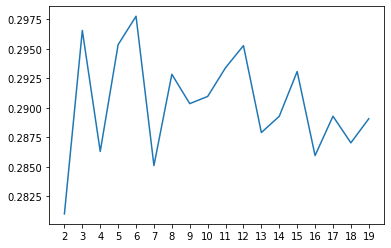

In [0]:
plt.plot(topics_nr, coherence_values_gensim)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 6
numtopics = 6
models.LdaModel(corpus, id2word=id2word, num_topics=numtopics).print_topics()

[(0,
  '0.006*"italiano" + 0.003*"daily" + 0.003*"roma" + 0.003*"giornale" + 0.003*"italia" + 0.003*"dispaccio" + 0.003*"telegrafico" + 0.002*"potere" + 0.002*"venire" + 0.002*"cardinale"'),
 (1,
  '0.006*"italiano" + 0.004*"roma" + 0.003*"italia" + 0.003*"potere" + 0.003*"daily" + 0.003*"telegrafico" + 0.002*"dispaccio" + 0.002*"giornale" + 0.002*"dire" + 0.002*"venire"'),
 (2,
  '0.005*"italiano" + 0.004*"italia" + 0.004*"dispaccio" + 0.003*"telegrafico" + 0.003*"potere" + 0.003*"venire" + 0.003*"roma" + 0.002*"daily" + 0.002*"mentire" + 0.002*"giornale"'),
 (3,
  '0.010*"italiano" + 0.004*"italia" + 0.004*"roma" + 0.004*"dispaccio" + 0.004*"telegrafico" + 0.003*"cardinale" + 0.003*"venire" + 0.003*"daily" + 0.003*"giornale" + 0.003*"potere"'),
 (4,
  '0.008*"italiano" + 0.005*"dispaccio" + 0.004*"italia" + 0.004*"roma" + 0.003*"telegrafico" + 0.003*"venire" + 0.003*"giornale" + 0.002*"potere" + 0.002*"daily" + 0.002*"papa"'),
 (5,
  '0.008*"italiano" + 0.004*"italia" + 0.004*"potere

### 2.4.2 LDA Mallet

In [0]:
#can take a long time to run
topics_nr = []
coherence_values_mallet = []
for num_topics in range(2, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_mallet.append(coherence_value)
  topics_nr.append(str(num_topics))
  print("Num Topics =", num_topics, " has Coherence Value of", round(coherence_value,4))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Num Topics = 2  has Coherence Value of 0.3151
Num Topics = 3  has Coherence Value of 0.3448
Num Topics = 4  has Coherence Value of 0.3766
Num Topics = 5  has Coherence Value of 0.3834
Num Topics = 6  has Coherence Value of 0.385
Num Topics = 7  has Coherence Value of 0.3609
Num Topics = 8  has Coherence Value of 0.3768
Num Topics = 9  has Coherence Value of 0.3961
Num Topics = 10  has Coherence Value of 0.4011
Num Topics = 11  has Coherence Value of 0.3986
Num Topics = 12  has Coherence Value of 0.3765
Num Topics = 13  has Coherence Value of 0.3752
Num Topics = 14  has Coherence Value of 0.3879
Num Topics = 15  has Coherence Value of 0.3665
Num Topics = 16  has Coherence Value of 0.3467
Num Topics = 17  has Coherence Value of 0.3683
Num Topics = 18  has Coherence Value of 0.36
Num Topics = 19  has Coherence Value of 0.3692


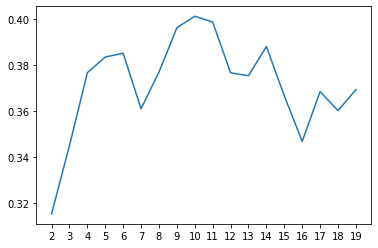

In [0]:
plt.plot(topics_nr, coherence_values_mallet)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 10
numtopics = 10
gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word).print_topics()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.009*"notizia" + 0.008*"daily" + 0.007*"piccolo" + 0.007*"follare" + 0.007*"lira" + 0.007*"solo" + 0.007*"sera" + 0.006*"altro" + 0.006*"gran" + 0.006*"prossimo"'),
 (1,
  '0.019*"dispaccio" + 0.017*"telegrafico" + 0.010*"mentire" + 0.009*"roma" + 0.009*"potere" + 0.006*"morto" + 0.005*"zione" + 0.005*"correre" + 0.005*"giugno" + 0.005*"vero"'),
 (2,
  '0.007*"americano" + 0.007*"york" + 0.007*"dirigere" + 0.006*"italia" + 0.006*"ebreo" + 0.006*"commerciare" + 0.006*"genova" + 0.006*"piroscafo" + 0.006*"vapore" + 0.005*"russia"'),
 (3,
  '0.028*"italiano" + 0.014*"venire" + 0.012*"potere" + 0.011*"trovare" + 0.010*"daily" + 0.010*"dire" + 0.010*"quotidiano" + 0.009*"italia" + 0.008*"italian" + 0.008*"parere"'),
 (4,
  '0.015*"italiano" + 0.009*"regina" + 0.007*"venire" + 0.007*"camera" + 0.006*"politico" + 0.006*"serbia" + 0.006*"italia" + 0.006*"vivo" + 0.005*"belgrado" + 0.005*"ufficiale"'),
 (5,
  '0.012*"leggere" + 0.007*"lottare" + 0.007*"potere" + 0.007*"sociale" + 0.006

# Topic distribution

## 3.1. Gensim

### 3.1.1. Distribution per topic and per document

In [0]:
%%capture
numtopics = 6
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)

In [0]:
distribution = pd.DataFrame(index=[i for i in range(len(corpus))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
for i in range(len(corpus)):
  row = [list(j)[1] for j in ldamodel[corpus[i]]] 
  distribution.loc[i] = row

In [0]:
# add file name
distribution.insert(0, 'document_path', sources['file_name'])

In [50]:
distribution

,document_path,topic0,topic1,topic2,topic3,topic4,topic5
0,2012271201_1903-08-01_ed-1_seq-1_ocr.txt,0.000223515,0.394424,0.603971,0.000934326,0.000223446,0.000223448
1,sn85066408_1903-06-22_ed-1_seq-1_ocr.txt,0.137688,0.15079,0.442622,0.268655,0.000122894,0.000122844
2,sn85066408_1903-06-19_ed-1_seq-1_ocr.txt,0.0252591,0.962672,0.000121861,0.00916961,0.000121882,0.00265559
3,sn85066408_1903-05-30_ed-1_seq-1_ocr.txt,0.005801,0.000138544,0.000138499,0.993645,0.000138616,0.000138445
4,2012271201_1903-07-18_ed-1_seq-1_ocr.txt,0.000221806,0.255294,0.107488,0.636553,0.000221791,0.00022177
...,...,...,...,...,...,...,...
95,sn85066408_1903-07-03_ed-1_seq-1_ocr.txt,0.000106379,0.000106388,0.000106508,0.999468,0.00010635,0.000106341
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.907267,0.00013225,0.000132354,0.000132397,0.00013233,0.0922035
97,sn85066408_1903-05-25_ed-1_seq-1_ocr.txt,0.0466253,0.730955,0.000109255,0.222092,0.000109304,0.000109251
98,sn85066408_1903-07-09_ed-1_seq-1_ocr.txt,0.453023,0.000111651,0.000111716,0.0428541,0.000111685,0.503788


### 3.1.2. Distribution per topic for the whole corpus

In [65]:
topics = []
topic_weights = []
for i in range(len(distribution.columns)-1):
  topic_weight = round(sum(distribution.iloc[:,i+1]),2)
  topic_weights.append(topic_weight)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldamodel.print_topics()[i][1]
  topics.append(i)
  print( f'terms: {topic} ')

topic 0: 12.33%
terms: 0.007*"italiano" + 0.005*"dispaccio" + 0.004*"roma" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"potere" + 0.003*"daily" + 0.003*"giornale" + 0.002*"venire" + 0.002*"cardinale" 
topic 1: 12.49%
terms: 0.007*"italiano" + 0.004*"italia" + 0.003*"dispaccio" + 0.003*"telegrafico" + 0.003*"roma" + 0.003*"daily" + 0.002*"giornale" + 0.002*"venire" + 0.002*"potere" + 0.002*"nuovo" 
topic 2: 11.2%
terms: 0.007*"italiano" + 0.004*"potere" + 0.004*"dispaccio" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"venire" + 0.003*"daily" + 0.003*"giornale" + 0.002*"roma" + 0.002*"cardinale" 
topic 3: 41.29%
terms: 0.008*"italiano" + 0.005*"roma" + 0.004*"italia" + 0.003*"venire" + 0.003*"dispaccio" + 0.003*"telegrafico" + 0.003*"cardinale" + 0.003*"giornale" + 0.002*"potere" + 0.002*"daily" 
topic 4: 6.54%
terms: 0.006*"italiano" + 0.004*"italia" + 0.004*"roma" + 0.003*"dispaccio" + 0.003*"potere" + 0.003*"venire" + 0.003*"telegrafico" + 0.003*"giornale" + 0.002*"daily" + 0.002

In [0]:
# dataframe with values to sort them by order of importance
distribution_df = pd.DataFrame(topic_weights, columns=['weight'])

In [0]:
distribution_df['topics'] = topics

In [0]:
distribution_df['topics'] = distribution_df['topics'].apply(lambda x: f'topic {x}')

In [0]:
distribution_df = distribution_df.sort_values(by=['weight'])

Text(0.5, 0, 'Weight (%)')

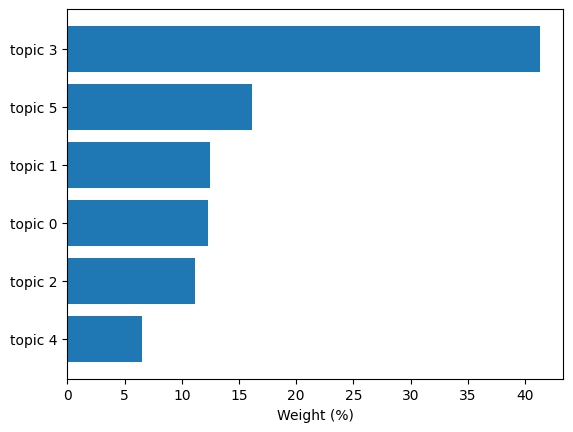

In [97]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(distribution_df['topics'], distribution_df['weight'], align='center')
ax.set_xlabel('Weight (%)')

##3.2 Mallet

### 3.2.1 Distribution per topic and per document

In [0]:
distribution_mallet = pd.DataFrame(index=[i for i in range(len(corpus))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
for i in range(len(corpus)):
  row = [list(j)[1] for j in ldamallet_to_gensim[corpus[i]]] 
  distribution_mallet.loc[i] = row

In [0]:
distribution_mallet.insert(0, 'document_path', sources['file_name'])

In [124]:
ldamallet_to_gensim.print_topics()

[(0,
  '0.000*"iwiwti" + 0.000*"teratamente" + 0.000*"avve" + 0.000*"innovatore" + 0.000*"coppati" + 0.000*"gior" + 0.000*"pensiero" + 0.000*"lentini" + 0.000*"aoljevando" + 0.000*"inintelligenti"'),
 (1,
  '0.000*"detur" + 0.000*"cevere" + 0.000*"hhnlllo" + 0.000*"processo" + 0.000*"strazione" + 0.000*"trovali" + 0.000*"nurmo" + 0.000*"ringra" + 0.000*"viticoltura" + 0.000*"italiamo"'),
 (2,
  '0.000*"sarono" + 0.000*"gevitch" + 0.000*"orologio" + 0.000*"pellicolare" + 0.000*"familiare" + 0.000*"trattamente" + 0.000*"nario" + 0.000*"lllntreltof" + 0.000*"esaltamento" + 0.000*"intimo"'),
 (3,
  '0.000*"vqjenterosl" + 0.000*"amaramente" + 0.000*"intereatlng" + 0.000*"inane" + 0.000*"jenninga" + 0.000*"ripar" + 0.000*"omsa" + 0.000*"cica" + 0.000*"soldataglia" + 0.000*"villico"'),
 (4,
  '0.000*"butl" + 0.000*"intravisto" + 0.000*"tunisi" + 0.000*"hoelon" + 0.000*"febbraio" + 0.000*"ciueato" + 0.000*"vistare" + 0.000*"libellista" + 0.000*"persecuzio" + 0.000*"puntare"'),
 (5,
  '0.000*"s

In [122]:
distribution_mallet

,document_path,topic0,topic1,topic2,topic3,topic4,topic5
0,2012271201_1903-08-01_ed-1_seq-1_ocr.txt,0.629896,0.0538779,0.0847292,0.0758448,0.0450106,0.110642
1,sn85066408_1903-06-22_ed-1_seq-1_ocr.txt,0.0668228,0.432995,0.10571,0.172866,0.180919,0.0406874
2,sn85066408_1903-06-19_ed-1_seq-1_ocr.txt,0.0856187,0.174186,0.0644502,0.1533,0.470623,0.0518224
3,sn85066408_1903-05-30_ed-1_seq-1_ocr.txt,0.0592887,0.267759,0.291093,0.098152,0.205883,0.077825
4,2012271201_1903-07-18_ed-1_seq-1_ocr.txt,0.648988,0.0785165,0.0596277,0.103883,0.0615078,0.047477
...,...,...,...,...,...,...,...
95,sn85066408_1903-07-03_ed-1_seq-1_ocr.txt,0.0657611,0.15875,0.13999,0.289093,0.296807,0.0495992
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.0515031,0.124818,0.139425,0.0925526,0.31812,0.273581
97,sn85066408_1903-05-25_ed-1_seq-1_ocr.txt,0.048888,0.240251,0.305703,0.111681,0.232258,0.0612189
98,sn85066408_1903-07-09_ed-1_seq-1_ocr.txt,0.0870415,0.213408,0.150612,0.201697,0.223258,0.123984


### 3.2.2. Distribution per topic for the whole corpus

In [123]:
topics = []
topic_weights = []
for i in range(len(distribution_mallet.columns)-1):
  topic_weight = round(sum(distribution_mallet.iloc[:,i+1]),2)
  topic_weights.append(topic_weight)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldamallet_to_gensim.print_topics()[i][1]
  topics.append(i)
  print( f'terms: {topic} ')

topic 0: 14.26%
terms: 0.000*"iwiwti" + 0.000*"teratamente" + 0.000*"avve" + 0.000*"innovatore" + 0.000*"coppati" + 0.000*"gior" + 0.000*"pensiero" + 0.000*"lentini" + 0.000*"aoljevando" + 0.000*"inintelligenti" 
topic 1: 20.01%
terms: 0.000*"detur" + 0.000*"cevere" + 0.000*"hhnlllo" + 0.000*"processo" + 0.000*"strazione" + 0.000*"trovali" + 0.000*"nurmo" + 0.000*"ringra" + 0.000*"viticoltura" + 0.000*"italiamo" 
topic 2: 17.99%
terms: 0.000*"sarono" + 0.000*"gevitch" + 0.000*"orologio" + 0.000*"pellicolare" + 0.000*"familiare" + 0.000*"trattamente" + 0.000*"nario" + 0.000*"lllntreltof" + 0.000*"esaltamento" + 0.000*"intimo" 
topic 3: 14.89%
terms: 0.000*"vqjenterosl" + 0.000*"amaramente" + 0.000*"intereatlng" + 0.000*"inane" + 0.000*"jenninga" + 0.000*"ripar" + 0.000*"omsa" + 0.000*"cica" + 0.000*"soldataglia" + 0.000*"villico" 
topic 4: 18.09%
terms: 0.000*"butl" + 0.000*"intravisto" + 0.000*"tunisi" + 0.000*"hoelon" + 0.000*"febbraio" + 0.000*"ciueato" + 0.000*"vistare" + 0.000*"lib

In [0]:
distribution_df_mallet = pd.DataFrame(topic_weights, columns=['weight'])

In [0]:
distribution_df_mallet['topics'] = topics

In [0]:
distribution_df_mallet['topics'] = distribution_df_mallet['topics'].apply(lambda x: f'topic {x}')

In [0]:
distribution_df_mallet = distribution_df_mallet.sort_values(by=['weight'])

Text(0.5, 0, 'Weight (%)')

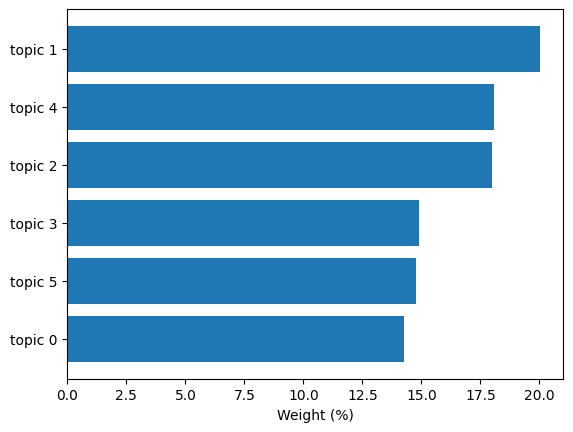

In [136]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(distribution_df_mallet['topics'], distribution_df_mallet['weight'], align='center')
ax.set_xlabel('Weight (%)')